# **Importing required Libraries**

In [67]:
import numpy as np
from scipy import signal
from matplotlib import pyplot as plt

# **ICA can be broken down into the following steps:**

### 1. Centering x by subtracting the mean
### 2. Whitening x
### 3. Choosing a random initial value for the de-mixing matrix w
### 4. Calculating the new value for w
### 5. Normalizing w
### 6. Checking whether algorithm has converged, if it doesn't repeat from step 4
### 7. Calculating the dot product of w and x to get the independent source signals

## **S = wx**


# **Defining function for centering x**

### *The task of this function is to center the signal by subtracting the mean*

In [54]:
def center(x):
  X = np.array(x)
  return X - X.mean(axis = 1, keepdims = True)

# **Defining function for whitening x**

### To “*whiten*” a given signal means that we transform it in such a way that potential correlations between its components are removed (*covariance equal to 0*) and the *variance of each component is equal to 1*. In other words the covariance matrix of the whitened signal is an *identity matrix*. Independent components must have zero correlation between each other and are assumed to be scaled to have unit variance each, thus is convenient.

### Whitening a signal involves the *eigen-value decomposition of its covariance matrix* described by the mathematical equation :

## ***x(hat) = E(D^-(1/2))(E^T)x***

### D : Diagonal matrix of eigenvalues
### E : Orthogonal matrix of eigenvectors

In [55]:
def whiten(X):
  x_cov = np.cov(X)  # covariance matrix
  d, E = np.linalg.eigh(x_cov)  # 'd' stores the eigen values which will be diagonalised, 'E' is the orthogonal matrix of eigenvectors
  D = np.diag(d)  # diagonal matrix of eigen values
  D_inv = np.sqrt(np.linalg.inv(D))
  return np.dot(E, np.dot(D_inv, np.dot(E.T, X)))

# **Defining functions for determining new values of de-mixing matrix 'w'**

In [56]:
def g(x):
  return np.tanh(x)

In [57]:
def g_bar(x):
  return 1-(np.tanh(x))**2

# **Defining function for updating de-mixing matrix 'w'**

In [58]:
def update_w(w, X):
  w_new = (X * g(np.dot(w.T, X))).mean(axis = 1) - g_bar(np.dot(w.T, X)).mean() * w
  return w_new/np.sqrt((w_new ** 2).sum())

# **Defining function to call the preprocessing functions and apply ICA**

In [59]:
def ica(X, iterations, limit = 1e-5):
  X = center(X)
  X = whiten(X)
  dim = X.shape[0]
  W = np.zeros((dim, dim), dtype=X.dtype)
  for i in range(dim):
        w = np.random.rand(dim)
        for j in range(iterations):
            w_new = update_w(w, X)
            if i >= 1:
                w_new -= np.dot(np.dot(w_new, W[:i].T), W[:i])
            distance = np.abs(np.abs((w * w_new).sum()) - 1)
            w = w_new
            if distance < limit:
                break
        W[i, :] = w
        S = np.dot(W, X)
  return S

# **Defining function for plotting and comparing the signals**

In [60]:
def plot_mixture_sources_predictions(X, original_sources, S):
    fig = plt.figure()
    plt.subplot(3, 1, 1)
    for x in X:
        plt.plot(x)
    plt.title("Mixed signals")
    plt.subplot(3, 1, 2)
    for s in original_sources:
        plt.plot(s)
    plt.title("Real source signals")
    plt.subplot(3,1,3)
    for s in S:
        plt.plot(s)
    plt.title("Predicted source signals")
    
    fig.tight_layout()
    plt.show()

# **Testing ICA on signals**

In [61]:
n_samples = 2000
time = np.linspace(0, 8, n_samples)
s1 = np.sin(2 * time)  # sinusoidal
s2 = np.sign(np.sin(3 * time))  # square signal
s3 = signal.sawtooth(2 * np.pi * time)  # saw tooth signal

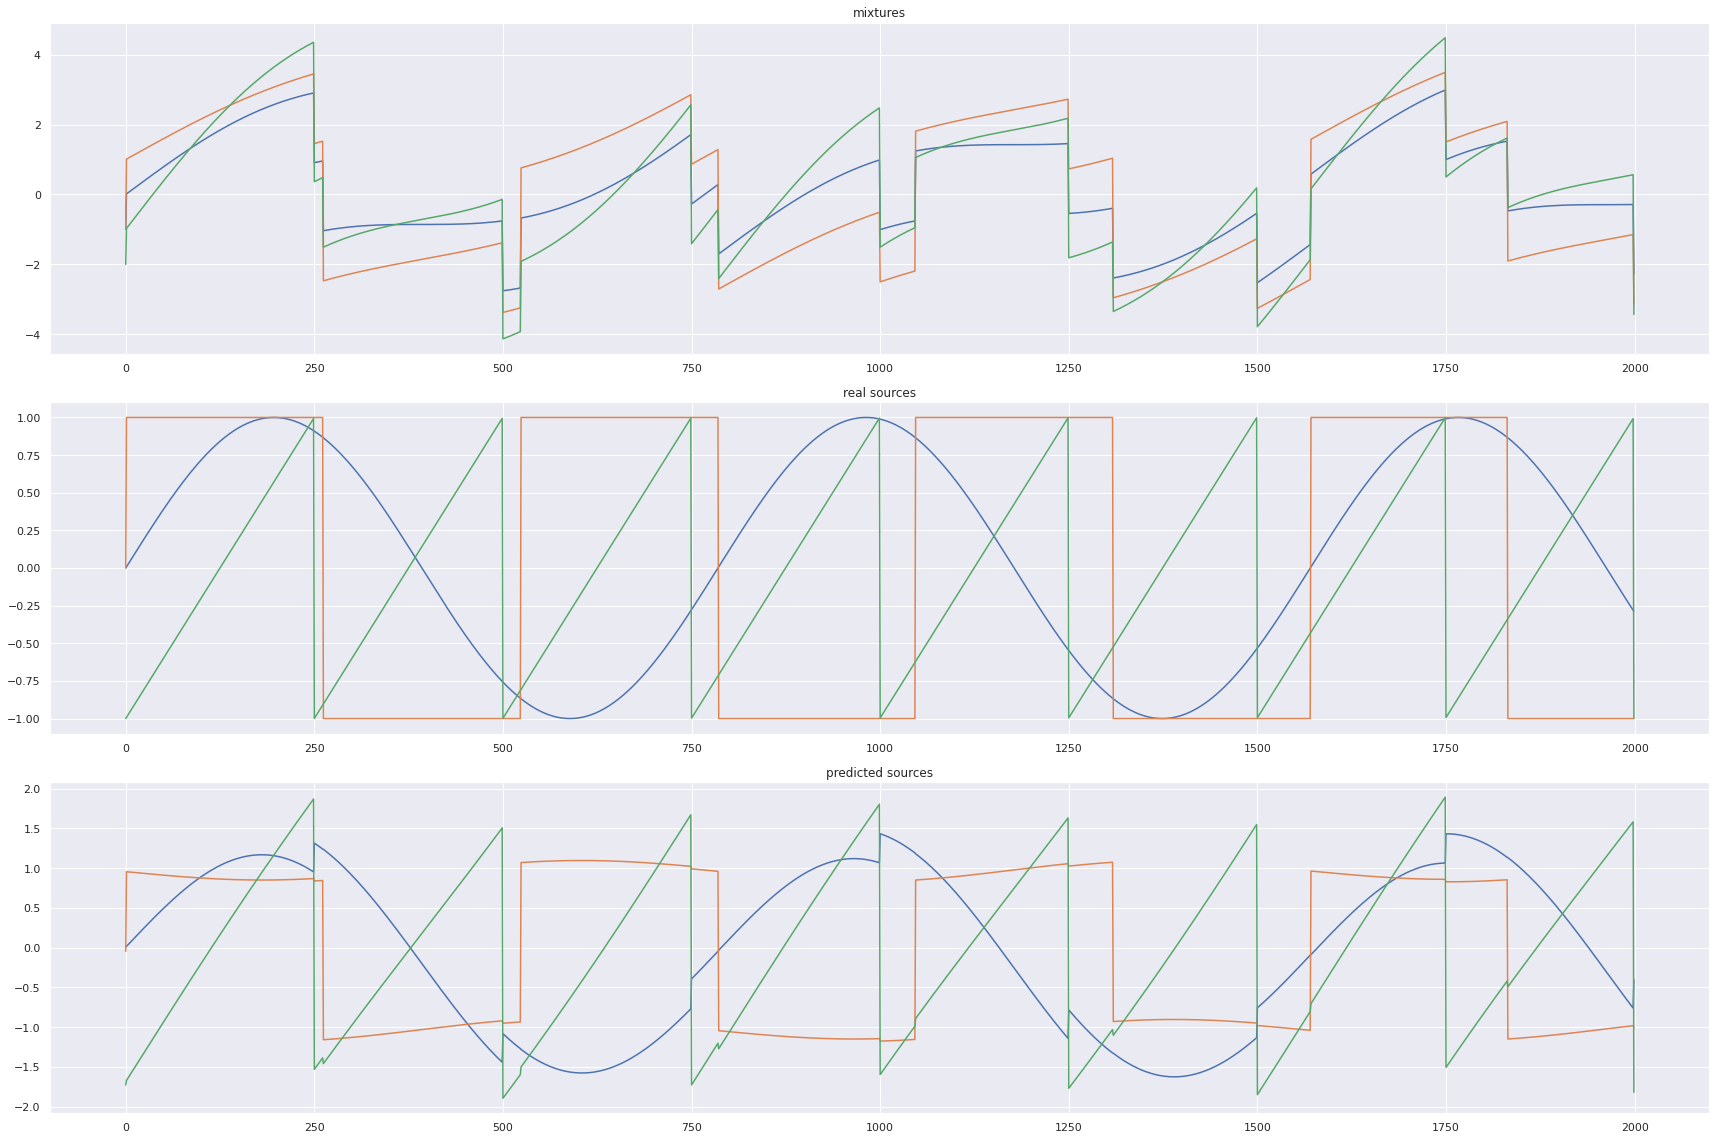

In [66]:
X = np.c_[s1, s2, s3]
A = np.array(([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]]))
X = np.dot(X, A.T)
X = X.T
S = ica(X, iterations=2500)
plot_mixture_sources_predictions(X, [s1, s2, s3], S)